## Grad CAM

In [1]:
import sys,os,h5py
import matplotlib.pyplot as plt
import numpy as np 
from argparse import Namespace

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

sys.path.append(os.path.dirname(os.getcwd())) #add parent folder to PATH
import lib.models as models
import seqlogo
from IPython.display import  display

INFO:transformers.file_utils:PyTorch version 1.4.0 available.


### instantiate model

In [2]:
class Experiment(pl.LightningModule):
    def __init__(self,model):
        super(Experiment, self).__init__()
        self.model = model
    def configure_optimizers(): pass
    def forward(): pass
    def training_step(): pass

In [3]:
hparams = {'emb': {'vocab_size':4, 'd_emb':4,'hot':True},
           'resnet': {'n_res_blocks':6, 'res_k':0, 'res_p':0.01, 
                      'block_stride':[2,1]*3,'C':32,'d':4,'bn_ks':3},
           'seq_model_name': None, 
           'seq_model': None,
           'lin': {'skip_cnt':False, 'fc_h_dim':512, 'lin_p':0.01},
           'train': {'bs':25, 'batch_acum':4},
           'optim_name':'torch.optim.AdamW',
           'optim':{'lr':1e-4,'betas':(0.5,0.999),'weight_decay':0}
          }
hparams['seq_model_name'] ='BiLSTM' 
hparams['seq_model'] = {'d_model':512,'p':0.01,'seq_len':125}
chpt_path = '../data/lightning_logs/version_55/checkpoints/_ckpt_epoch_5.ckpt'

In [4]:
seq_model = eval('models.'+ hparams['seq_model_name'])(**hparams['seq_model'])
model = models.ResSeqLin(**hparams['emb'], seq_model=seq_model, 
                         **hparams['resnet'], **hparams['lin'])

exp = Experiment(model)
exp.load_state_dict(torch.load(chpt_path)['state_dict'])
_ = model.eval()

In [5]:
seq_model = eval('models.'+ hparams['seq_model_name'])(**hparams['seq_model'])
guided_model = models.ResSeqLin(**hparams['emb'], seq_model=seq_model, 
                         **hparams['resnet'], **hparams['lin'])

exp = Experiment(guided_model)
exp.load_state_dict(torch.load(chpt_path)['state_dict'])
_ = guided_model.eval()

In [119]:
test = np.load('../data/Processed/test.npz')
# X_test = torch.tensor(test['arr_0'][:])
sample = torch.tensor(test['arr_0'][333]).long()

if hparams['emb']['hot']:
    x_hot = torch.zeros(4,1000)
    x_hot[sample,np.arange(1000)]=1
    x = x_hot[None] # add batch dim
else:
    x = sample[None] # add batch dim
    
seq_len = x.shape[-1]

In [107]:
tgt = 832 #target to find common motif
tgt_idxs = test['arr_1'][:500][:,832]==1
sample_batch = test['arr_0'][:500][tgt_idxs]

bs = sample_batch.shape[0]
print(bs)
hot_batch = torch.zeros(bs,4,seq_len)
for i in range(bs):
    x = torch.LongTensor(sample_batch[i])
    hot_batch[i,x,np.arange(seq_len)]=1

40


### viz

In [115]:
def plot_seq(seq,title=None):
    ''' Arguments:
        seq: (seq_len,)
    '''
    r=seq_len//seq.shape[0]
    seq = seq[None,:]
    extended = np.repeat(np.repeat(seq,r,1),50,0)
    fig, ax = plt.subplots(figsize=(16,16))
    ax.get_yaxis().set_ticks([])
    ax.set_title(title)
    ax.imshow(extended,cmap='jet')

def topk_seq(grad_cam,k,back_grad):
    r=1000//grad_cam.shape[0]
    extended = np.repeat(grad_cam,r)
    if back_grad!= None: extended *= back_grad.numpy()
    max_i, max_v = 0, 0
    for i in range(1000-k):
        v = extended[i:i+7].sum()
        if v > max_v: 
            max_i = i
            max_v = v
    return max_i  

def arr2seq(arr):
    bases = ('A','G','C','T')
    sample = []
    for i in arr:
        sample.append(bases[i])
    return sample   

def relu_tensor(x): return F.relu(torch.tensor(x))

In [8]:
# Guide backpropagation
# https://arxiv.org/pdf/1412.6806.pdf
# https://github.com/kazuto1011/grad-cam-pytorch/blob/master/grad_cam.py

guided_handlers = []

for i in guided_model.modules():
    if isinstance(i, nn.ReLU):
        def backward_hook(module, grad_in, grad_out):
            return (F.relu(grad_in[0]),)
        guided_handlers.append(i.register_backward_hook(backward_hook))

x.requires_grad_(True)

tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.]], requires_grad=True)

In [9]:
# https://arxiv.org/pdf/1610.02391.pdf
# https://course.fast.ai/videos/?lesson=6

global saved_acts
global saves_grads

saved_acts = {}
saves_grads= {}
handlers = []

def layer_hooks(layer,id):

    def save_activations(module, input, output):
        global saved_acts
        saved_acts[id] = output

    def save_gradients(module, grad_input, grad_output):
        global saves_grads
        saves_grads[id] = grad_output[0] #grads are tuples
        
    fwd_handle = layer.register_forward_hook(save_activations)
    bwd_handle = layer.register_backward_hook(save_gradients)
    handlers.append(fwd_handle)
    handlers.append(bwd_handle)
    
# Layer to visualize the activations from
last_cv = model.res.layers[-1] # for high lvl features
first_cv = model.res.layers[0] # for motifs

layer_hooks(last_cv,'last_cv')
layer_hooks(first_cv,'first_cv')

In [67]:
# Forward pass
y_hat = model(x)
y_pred = torch.sigmoid(y_hat[0])
y_hat2 = guided_model(x)
# print(saved_acts.shape)

# We choose the class with highest probability, can be a choosen label
_, i = y_pred.topk(1)
# i=888
# gradient backpropagation
guided_model.zero_grad()
y_hat2[0][0,i].backward()
back_grad = F.relu(x.grad.clone().sum(0))

model.zero_grad()
y_hat[0][0,i].backward()
x.grad.zero_()
# print(saved_acts[0].shape, saves_grads[0].shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [75]:
y_pred.topk(10)

torch.return_types.topk(
values=tensor([[0.9693, 0.9472, 0.9457, 0.8755, 0.8680, 0.8638, 0.8523, 0.8475, 0.8411,
         0.7883]], grad_fn=<TopkBackward>),
indices=tensor([[832, 831, 870, 859, 915, 871, 893, 892, 916, 860]]))

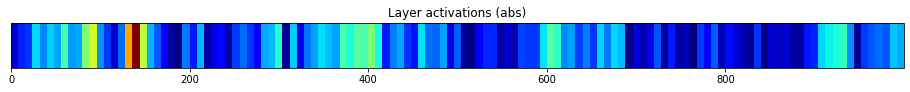

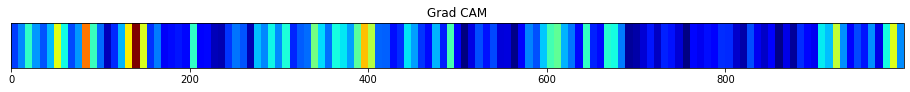

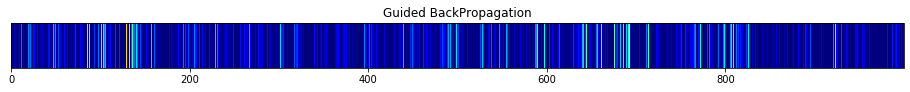

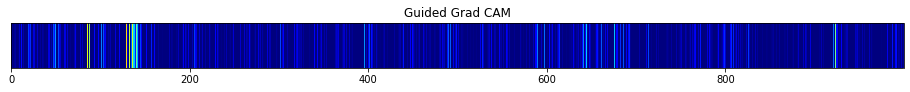

In [116]:
# Mean of the activation of every filter for every class
act_avg = saved_acts['last_cv'][0].detach().mean(0).numpy()
plot_seq(abs(act_avg),'Layer activations (abs)')

alpha_c = saves_grads['last_cv'][0].mean(1,keepdim=True) #weight factor for every filter according to gradients, represent how much affect the choosen class
# grad_cam = F.relu((alpha_c*saved_acts[0]).sum(0)).detach().numpy() #Grad-CAM over every filter
grad_cam = F.relu(alpha_c*saved_acts['last_cv'][0]).sum(0).detach().numpy() # grad cam modified
# print(alpha_c.shape, grad_cam.shape)
gd_grad_cam = np.repeat(grad_cam,seq_len//grad_cam.shape[0])* back_grad.numpy()

    
plot_seq(grad_cam,'Grad CAM')
plot_seq(back_grad,'Guided BackPropagation')
plot_seq(gd_grad_cam,'Guided Grad CAM')

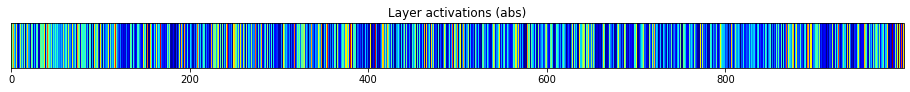

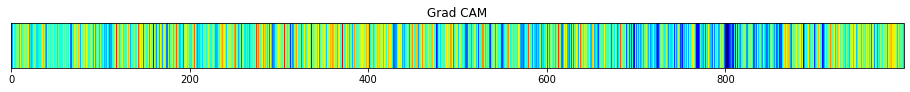

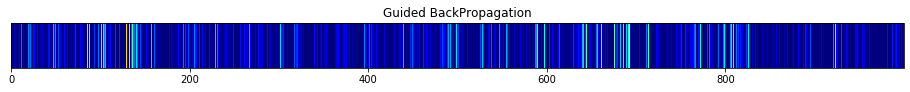

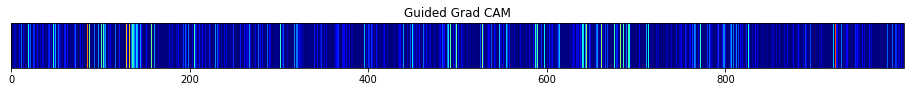

In [118]:
act_avg = saved_acts['first_cv'][0].detach().mean(0).numpy()
plot_seq(abs(act_avg),'Layer activations (abs)')

alpha_c1 = saves_grads['first_cv'][0].mean(1,keepdim=True) #weight factor for every filter according to gradients, represent how much affect the choosen class
# grad_cam = F.relu((alpha_c1*saved_acts['first_cv'][0]).sum(0)).detach().numpy() #Grad-CAM over every filter
grad_cam1 = F.relu(alpha_c1*saved_acts['first_cv'][0]).sum(0).detach().numpy() # grad cam modified
gd_grad_cam1 = np.repeat(grad_cam1,seq_len//grad_cam1.shape[0])* back_grad.numpy()

plot_seq(grad_cam1,'Grad CAM')
plot_seq(back_grad,'Guided BackPropagation')
plot_seq(gd_grad_cam1,'Guided Grad CAM')

In [41]:
i = topk_seq(grad_cam,7,back_grad)
i,arr2seq(sample[i:i+7])

(135, ['G', 'C', 'G', 'C', 'G', 'C', 'C'])

### first layer weigts

In [10]:
assert hparams['emb']['hot']

In [50]:
first_layer = model.res.layers[0]

filter_i = (alpha_c1*saved_acts['first_cv'][0]).sum(1).topk(1,0)[1].item() # most relevant filter for the class
#filter_i = alpha_c1.topk(1,0)[1].item() 
print(filter_i)
first_filter = first_layer.weight[filter_i].detach().numpy().astype('float64')

29


In [51]:
min_zero = first_filter - first_filter.min()
p = (min_zero/min_zero.sum(0))

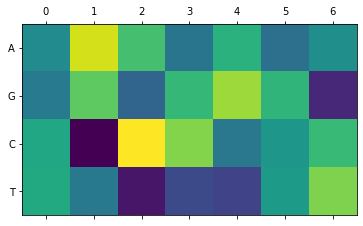

In [54]:
fig,ax = plt.subplots()
ax.matshow(p)
ax.set_yticklabels(['','A','G','C','T'])
plt.show()

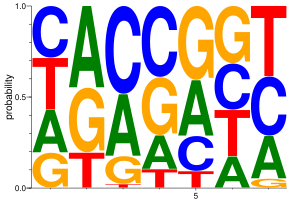

In [59]:
ppm = seqlogo.Ppm(p[[0,2,1,3],:])
seqlogo.seqlogo(ppm, ic_scale = False, format = 'svg', size = 'small')

### sintetic motif

In [ ]:
# https://distill.pub/2017/feature-visualization/

In [179]:
rand_input = torch.rand(1,4,1000,requires_grad=True)
rand_input

tensor([[[0.9574, 0.5913, 0.8258,  ..., 0.6248, 0.6024, 0.1421],
         [0.4424, 0.6179, 0.1395,  ..., 0.7997, 0.2130, 0.0871],
         [0.4894, 0.6662, 0.0806,  ..., 0.0585, 0.2206, 0.6247],
         [0.8293, 0.5889, 0.2734,  ..., 0.1713, 0.9539, 0.8046]]],
       requires_grad=True)

In [180]:
opt = torch.optim.Adam([rand_input])

In [183]:
for i in range(10):
    y_hat = model(rand_input)
    y_hat[0][0,888].backward()
    opt.step()
    model.zero_grad()
    rand_input.grad.zero_()

In [184]:
rand_input

tensor([[[0.9467, 0.5803, 0.8274,  ..., 0.6255, 0.5916, 0.1426],
         [0.4315, 0.6288, 0.1505,  ..., 0.7973, 0.2036, 0.0963],
         [0.4990, 0.6771, 0.0698,  ..., 0.0630, 0.2101, 0.6348],
         [0.8186, 0.5993, 0.2626,  ..., 0.1606, 0.9649, 0.7968]]],
       requires_grad=True)

### high layer motifs WIP

In [113]:
#avg motif:
ms = 7 #take every input of size kernel size
pad = torch.tensor([-1]*(ms//2))
pad_sample = torch.cat((pad,sample,pad))

positions = torch.zeros(seq_len,ms).fill_(-1) # -1 for padding
for i in range(seq_len):
    positions[i] = pad_sample[i:i+ms]

In [114]:
positions

tensor([[-1., -1., -1.,  ...,  2.,  3.,  2.],
        [-1., -1.,  3.,  ...,  3.,  2.,  3.],
        [-1.,  3.,  2.,  ...,  2.,  3.,  2.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])

In [25]:
def plot_PWM(acts):
    # count bases for each postion of ks and weight with grad cam
    pos_weight_counts = np.zeros((5,ks))
    for c in range(ks):
        for n in range(-1,4):
            weight_counts = acts[positions[:,c]==n].sum()
            pos_weight_counts[n+1,c] = weight_counts
            
    # PWM graph
#     fig,ax = plt.subplots()
#     ax.matshow(pos_weight_counts)
#     ax.set_yticklabels(['']+['PAD','A','G','C','T'])
#     plt.show()
    p = (pos_weight_counts[1:]/pos_weight_counts[1:].sum(0))
    ppm = seqlogo.Ppm(p)
    return seqlogo.seqlogo(ppm, ic_scale = False, format = 'svg', size = 'small')

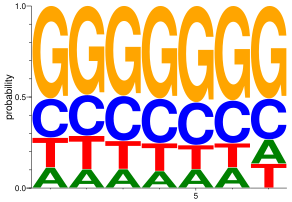

In [26]:
plot_PWM(grad_cam)

###  remove handlers

In [ ]:
for i in handlers+guided_handlers: i.remove()

In [ ]:
# grad cam ++ https://arxiv.org/pdf/1710.11063.pdf
# plot weight of first layer filters http://cs231n.github.io/understanding-cnn/
# plot on the input local high level features separated
# calculate population metrics of certain label with averaging over a set of samples and plot weights of first layer

## loss graphs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
chpt_lstm = '../data/lightning_logs/version_55/metrics.csv'
chpt_txl  = '../data/lightning_logs/version_51/metrics.csv'

In [32]:
csv = pd.read_csv(chpt_lstm)
csv['created_at'] =  pd.to_datetime(csv['created_at'], format='%Y%m%d %H:%M:%S.%f')
csv['created_at'] =  (csv['created_at'] - csv['created_at'][csv.first_valid_index()]).dt.total_seconds()
csv = csv.set_index('created_at')
csv

,train_loss,epoch,val_loss,valid_roc_auc,valid_acc
created_at,,,,,
0.000000,0.098585,0,NaN,NaN,NaN
0.620962,0.078722,0,NaN,NaN,NaN
1.192734,0.077337,0,NaN,NaN,NaN
1.758596,0.093673,0,NaN,NaN,NaN
2.333053,0.084425,0,NaN,NaN,NaN
...,...,...,...,...,...
90263.430217,0.076333,5,NaN,NaN,NaN
90264.674053,0.066951,5,NaN,NaN,NaN
90265.928700,0.055678,5,NaN,NaN,NaN


In [56]:
def plot_losses(csv_path, ax,avg_win_sz=500,time=False):
    csv = pd.read_csv(csv_path)
    if time:
        csv['created_at'] =  pd.to_datetime(csv['created_at'], format='%Y%m%d %H:%M:%S.%f')
        csv['Seconds'] =  (csv['created_at'] - csv['created_at'][csv.first_valid_index()]).dt.total_seconds()
        csv = csv.set_index('Seconds')

    trn = csv[csv['train_loss'].notnull()]
    trn['train_loss'].rolling(avg_win_sz).mean().plot(ax=ax)
  
    val = csv[csv['val_loss'].notnull()]
    val['val_loss'].plot(ax=ax)

In [57]:
def plot_roc_auc(csv_path,ax,time=False):
    csv = pd.read_csv(csv_path)
    if time:
        csv['created_at'] =  pd.to_datetime(csv['created_at'], format='%Y%m%d %H:%M:%S.%f')
        csv['Seconds'] =  (csv['created_at'] - csv['created_at'][csv.first_valid_index()]).dt.total_seconds()
        csv = csv.set_index('Seconds')
        
    val = csv[csv['val_loss'].notnull()]
    val['valid_roc_auc'].plot(ax=ax)

Text(0.5, 1.0, 'ROC AUC vs time')

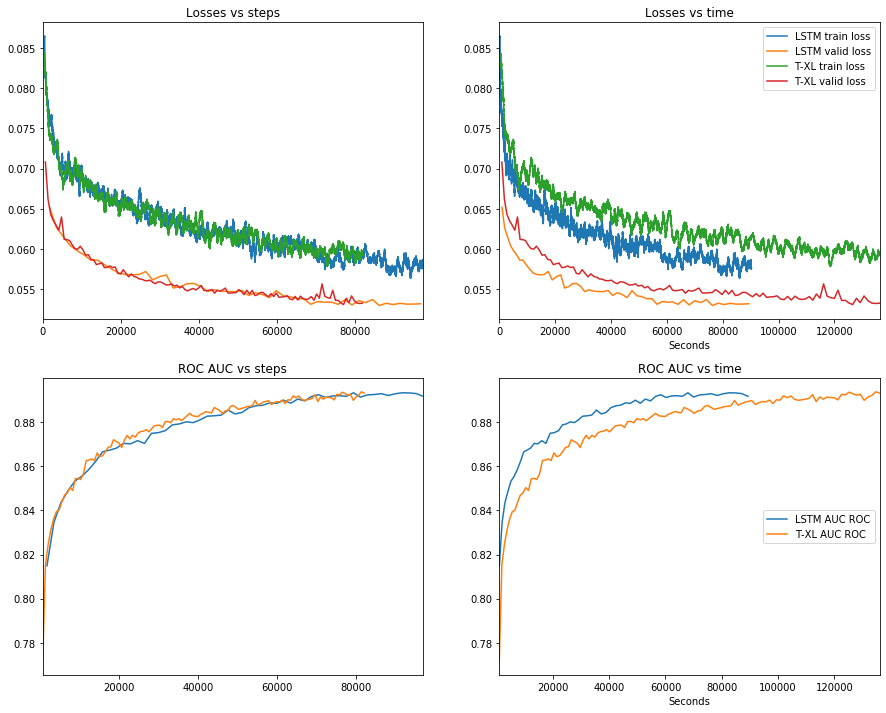

In [60]:
fig, axs = plt.subplots(2,2,figsize=(15,12))

plot_losses(chpt_lstm,axs[0,0])
plot_losses(chpt_txl, axs[0,0])
axs[0,0].set_title('Losses vs steps')

plot_losses(chpt_lstm,axs[0,1],time=True)
plot_losses(chpt_txl, axs[0,1],time=True)
axs[0,1].legend(['LSTM train loss','LSTM valid loss','T-XL train loss','T-XL valid loss'])
axs[0,1].set_title('Losses vs time')

plot_roc_auc(chpt_lstm,axs[1,0])
plot_roc_auc(chpt_txl, axs[1,0])
axs[1,0].set_title('ROC AUC vs steps')

plot_roc_auc(chpt_lstm,axs[1,1],time=True)
plot_roc_auc(chpt_txl, axs[1,1] ,time=True)
plt.legend(['LSTM AUC ROC','T-XL AUC ROC'],loc="center right")
axs[1,1].set_title('ROC AUC vs time')